# Chapter 5. Entity-level sentiment analysis
This notebook is complementary material to Chapter 5. of the thesis.

# Entity Level Sentiment Analysis

- [Hugging Face dataset source](https://huggingface.co/datasets/yixuantt/FinEntity)

In [ ]:
%pip install -q -r requirements.txt

In [2]:
# You need to login to your Hugging Face account to use the CLI or contact me to get the token
!huggingface-cli login --token YOUR_TOKEN

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
# Load the dataset

from datasets import load_dataset
import pandas as pd

ds = load_dataset("yixuantt/FinEntity")
df = ds["train"].to_pandas()

display(df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/979 [00:00<?, ? examples/s]

,content,annotations
0,Johnson & Johnson <JNJ.N> shares gained 0.20% ...,"[{'end': 17, 'label': 'Positive', 'start': 0, ..."
1,"On the positive side, Siemens is rallying 6% a...","[{'end': 107, 'label': 'Positive', 'start': 98..."
2,Brent crude <LCOc1> rose 1.4% to $100.69 per b...,"[{'end': 11, 'label': 'Positive', 'start': 0, ..."
3,"Nearly all major S&P 500 sectors are red, with...","[{'end': 162, 'label': 'Positive', 'start': 15..."
4,NEW YORK - Wall Street ended sharply higher on...,"[{'end': 69, 'label': 'Positive', 'start': 64,..."
...,...,...
974,"""We expect the wheat crop to be close to last ...","[{'end': 272, 'label': 'Neutral', 'start': 265..."
975,"Chipmakers, including Infineon <IFXGn.DE> and ...","[{'end': 30, 'label': 'Negative', 'start': 22,..."
976,Coca-Cola Co <KO.N> rose 2.4% after the compan...,"[{'end': 12, 'label': 'Positive', 'start': 0, ..."
977,"The Nikkei <.N225> rose 1.21% to 27,527.64, in...","[{'end': 107, 'label': 'Positive', 'start': 10..."


- Delete all \<ticker\> mentions in content and add them to annotations objects


In [4]:
import re


def find_and_remove_tickers(row):
    """
    Find all substrings enclosed in '<' and '>' in the 'content' column of the DataFrame,
    and remove them from the 'content'. Additionally delete the '<', '>' and everything
    after '.' from the ticker.
    """
    matches = re.finditer("<(.*?)>", row["content"])
    tickers = []
    for match in matches:
        start = match.start()
        end = match.end()
        ticker = match.group()
        # Remove the '<', '>' and everything after '.' from the ticker
        ticker = re.sub("<|>|(\..*)", "", ticker)
        tickers.append({"start": start, "end": end, "ticker": ticker})

    # Remove the tickers from the 'content'
    cleaned_content = re.sub("<(.*?)>", "", row["content"])

    return tickers, cleaned_content


def add_tickers(row):
    """
    Add the tickers to the 'annotations' column
    if a ticker's 'start' is equal to an annotation's 'end' + 1,
    """
    tickers = row["tickers"]
    annotations = row["annotations"]
    for ticker in tickers:
        for annotation in annotations:
            if ticker["start"] == annotation["end"] + 1:
                annotation["ticker"] = ticker["ticker"]
    for annotation in annotations:
        if "ticker" not in annotation:
            annotation["ticker"] = ""
    return annotations


df["tickers"], df["content"] = zip(*df.apply(find_and_remove_tickers, axis=1))
df["annotations"] = df.apply(add_tickers, axis=1)

# Delete the 'tickers' column
df = df.drop(columns=["tickers"])

display(df)

,content,annotations
0,Johnson & Johnson shares gained 0.20% after p...,"[{'end': 17, 'label': 'Positive', 'start': 0, ..."
1,"On the positive side, Siemens is rallying 6% a...","[{'end': 107, 'label': 'Positive', 'start': 98..."
2,Brent crude rose 1.4% to $100.69 per barrel a...,"[{'end': 11, 'label': 'Positive', 'start': 0, ..."
3,"Nearly all major S&P 500 sectors are red, with...","[{'end': 162, 'label': 'Positive', 'start': 15..."
4,NEW YORK - Wall Street ended sharply higher on...,"[{'end': 69, 'label': 'Positive', 'start': 64,..."
...,...,...
974,"""We expect the wheat crop to be close to last ...","[{'end': 272, 'label': 'Neutral', 'start': 265..."
975,"Chipmakers, including Infineon and BE Semicon...","[{'end': 30, 'label': 'Negative', 'start': 22,..."
976,Coca-Cola Co rose 2.4% after the company uppe...,"[{'end': 12, 'label': 'Positive', 'start': 0, ..."
977,"The Nikkei rose 1.21% to 27,527.64, in its bi...","[{'end': 107, 'label': 'Positive', 'start': 10..."


- For better testing accuracy we need to filter out annotations that do not obtain any ticker mentions from NASDAQ (Q82059), NASDAQ Stockholm AB (Q1019992), NYSE (Q13677), NYSE American (Q846626)
- We will use the symbols from the exchanges (in `../data/symbols` from https://www.eoddata.com) to filter out the annotations that do not contain any ticker mentions from the above exchanges


In [5]:
import pandas as pd
import csv

# For google colab use the path "/content/data/symbols/<exchange>.csv"
# For local use the path "data/symbols/<exchange>.csv"

# Read the CSV file of without considering quotes
nasdaq_df = pd.read_csv(
    "/content/data/symbols/NASDAQ.csv", sep="\t", quoting=csv.QUOTE_NONE, header=0
)

nyse_df = pd.read_csv(
    "/content/data/symbols/NYSE.csv", sep="\t", quoting=csv.QUOTE_NONE, header=0
)

amex_df = pd.read_csv(
    "/content/data/symbols/AMEX.csv", sep="\t", quoting=csv.QUOTE_NONE, header=0
)

# Remove quotes from each column
nasdaq_df = nasdaq_df.apply(lambda x: x.str.replace('"', ""))
nyse_df = nyse_df.apply(lambda x: x.str.replace('"', ""))
amex_df = amex_df.apply(lambda x: x.str.replace('"', ""))

# Remove quotes from the column names
nasdaq_df.columns = nasdaq_df.columns.str.replace('"', "")
nyse_df.columns = nyse_df.columns.str.replace('"', "")
amex_df.columns = amex_df.columns.str.replace('"', "")

# Rename the columns
nasdaq_df.rename(columns={"Symbol": "ticker", "Description": "name"}, inplace=True)
nyse_df.rename(columns={"Symbol": "ticker", "Description": "name"}, inplace=True)
amex_df.rename(columns={"Symbol": "ticker", "Description": "name"}, inplace=True)

print("NASDAQ")
display(nasdaq_df.head())
display(nasdaq_df.count())
print("\n")

print("NYSE")
display(nyse_df.head())
display(nyse_df.count())
print("\n")

print("AMEX")
display(amex_df.head())
display(amex_df.count())
print("\n")

NASDAQ


,ticker,name
0,AACG,Ata Creativity Global ADR
1,AACI,Armada Acquisition Corp I
2,AACIU,Armada Acquisition Corp I
3,AACIW,Armada Acquisition Corp I WT
4,AADI,Aadi Biosciences Inc


ticker    5073
name      5073
dtype: int64



NYSE


,ticker,name
0,A,Agilent Technologies
1,AA,Alcoa Corp
2,AAC,Ares Acquisition Corp Cl A
3,AAC.S,Ares Acquisition Corp II [Aact.U]
4,AAC.T,Ares Acquisition Corp II [Aact.Ws]


ticker    3102
name      3101
dtype: int64



AMEX


,ticker,name
0,AAA,First Priority Clo Bond ETF
1,AAAU,GS Physical Gold ETF
2,AAMC,Altisource Asset Management Corp Com
3,AAPX,T-Rex 2X Long Apple Daily Target ETF
4,AAPY,Neos Strategy Apple [Aapl] ETF


ticker    3165
name      3165
dtype: int64

In [6]:
# If columns count in each dataset is not equal, then ensure which records are uncomplete and delete them


# NASDAQ
print("NASDAQ")
display(nasdaq_df[nasdaq_df.isnull().any(axis=1)])

# Drop the rows with missing values
nasdaq_df.dropna(inplace=True)
print("\n")


# NYSE
print("NYSE")
display(nyse_df[nyse_df.isnull().any(axis=1)])

# Drop the rows with missing values
nyse_df.dropna(inplace=True)
print("\n")


# AMEX
print("AMEX")
display(amex_df[amex_df.isnull().any(axis=1)])

# Drop the rows with missing values
amex_df.dropna(inplace=True)
print("\n")

NASDAQ


,ticker,name




NYSE


,ticker,name
2039,NTEST.I,NaN




AMEX


,ticker,name


In [7]:
# Concatenate two dataframes into a single one with ticker alphabetical order
tickers_df = pd.concat([nasdaq_df, nyse_df, amex_df]).sort_values(by="ticker")

# Reset the index
tickers_df.reset_index(drop=True, inplace=True)

display(tickers_df)

,ticker,name
0,A,Agilent Technologies
1,AA,Alcoa Corp
2,AAA,First Priority Clo Bond ETF
3,AAAU,GS Physical Gold ETF
4,AAC,Ares Acquisition Corp Cl A
...,...,...
11334,ZVRA,Zevra Therapeutics Inc
11335,ZVSA,Zyversa Therapeutics Inc
11336,ZWS,Zurn Elkay Water Solutions Corp
11337,ZYME,Zymeworks Inc


In [8]:
# Number of all contents
print("Number of all contents ", len(df))

# Number of all annotation items
print(
    "Number of all annotation items ",
    sum(df["annotations"].map(lambda x: len(x))),
)

# Number of annotation items that has empty 'ticker' field
print(
    "Number of annotation items that has empty 'ticker' field ",
    sum(
        df["annotations"].map(
            lambda x: sum([annotation["ticker"] == "" for annotation in x])
        )
    ),
)

# Number of annotation items that has non-empty 'ticker' field
print(
    "Number of annotation items that has non-empty 'ticker' field ",
    sum(
        df["annotations"].map(
            lambda x: sum([annotation["ticker"] != "" for annotation in x])
        )
    ),
)

# Number of annotation items that are in the tickers_df
print(
    "Number of annotation items that are in the tickers_df ",
    sum(
        df["annotations"].map(
            lambda x: sum(
                [
                    annotation["ticker"] in tickers_df["ticker"].values
                    for annotation in x
                ]
            )
        )
    ),
)


# Delete each annotation item if the 'ticker' field is empty
def remove_empty_tickers(row):
    annotations = row["annotations"]
    annotations = [
        annotation for annotation in annotations if annotation["ticker"] != ""
    ]
    return annotations


df["annotations"] = df.apply(remove_empty_tickers, axis=1)


# Delete each annotation item if the 'ticker' field is not in the tickers_df
def remove_unrecognized_tickers(row):
    annotations = row["annotations"]
    annotations = [
        annotation
        for annotation in annotations
        if annotation["ticker"] in tickers_df["ticker"].values
    ]
    return annotations


df["annotations"] = df.apply(remove_unrecognized_tickers, axis=1)

# Delete each content if the annotations is empty
df = df[df["annotations"].map(len) > 0]

print("Number of all contents after cleaning", len(df))
display(df)

Number of all contents  979
Number of all annotation items  2131
Number of annotation items that has empty 'ticker' field  1359
Number of annotation items that has non-empty 'ticker' field  772
Number of annotation items that are in the tickers_df  540
Number of all contents after cleaning 282


,content,annotations
0,Johnson & Johnson shares gained 0.20% after p...,"[{'end': 17, 'label': 'Positive', 'start': 0, ..."
5,Levi Strauss & Co gained 2% after its quarter...,"[{'end': 17, 'label': 'Positive', 'start': 0, ..."
6,"However, top oilfield services company Schlumb...","[{'end': 51, 'label': 'Positive', 'start': 39,..."
7,"JPMorgan Chase & Co , Morgan Stanley , Cit...","[{'end': 69, 'label': 'Negative', 'start': 56,..."
13,Wall Street's main indexes gapped to the upsid...,"[{'end': 132, 'label': 'Positive', 'start': 11..."
...,...,...
967,Rival Oracle says in a statement on its websi...,"[{'end': 12, 'label': 'Neutral', 'start': 6, '..."
969,Facebook-owner Meta Platforms and Microsoft ...,"[{'end': 52, 'label': 'Neutral', 'start': 43, ..."
970,"Apple Inc , Samsung Electronics , Vivo, Xiaomi...","[{'end': 9, 'label': 'Neutral', 'start': 0, 't..."
973,Several heavyweight private equity funds have ...,"[{'end': 175, 'label': 'Neutral', 'start': 165..."


In [9]:
# Number of all items in annotations
print(
    "Number of all items in annotations ",
    sum(df["annotations"].map(lambda x: len(x))),
)

Number of all items in annotations  540


In [10]:
# Delete useless data


# Delete 'end', 'start', and 'tag' fields from the 'annotations' column, 'tag' and 'label' fields are the same, so we can delete one of them
def delete_useless_data(row):
    annotations = row["annotations"]
    for annotation in annotations:
        del annotation["end"]
        del annotation["start"]
        del annotation["tag"]
    return annotations


df["annotations"] = df.apply(delete_useless_data, axis=1)

display(df)

<ipython-input-10-abe4862fa6c8>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["annotations"] = df.apply(delete_useless_data, axis=1)


,content,annotations
0,Johnson & Johnson shares gained 0.20% after p...,"[{'label': 'Positive', 'value': 'Johnson & Joh..."
5,Levi Strauss & Co gained 2% after its quarter...,"[{'label': 'Positive', 'value': 'Levi Strauss ..."
6,"However, top oilfield services company Schlumb...","[{'label': 'Positive', 'value': 'Schlumberger'..."
7,"JPMorgan Chase & Co , Morgan Stanley , Cit...","[{'label': 'Negative', 'value': 'Citigroup Inc..."
13,Wall Street's main indexes gapped to the upsid...,"[{'label': 'Positive', 'value': 'Johnson & Joh..."
...,...,...
967,Rival Oracle says in a statement on its websi...,"[{'label': 'Neutral', 'value': 'Oracle', 'tick..."
969,Facebook-owner Meta Platforms and Microsoft ...,"[{'label': 'Neutral', 'value': 'Microsoft', 't..."
970,"Apple Inc , Samsung Electronics , Vivo, Xiaomi...","[{'label': 'Neutral', 'value': 'Apple Inc', 't..."
973,Several heavyweight private equity funds have ...,"[{'label': 'Neutral', 'value': 'Blackstone', '..."


## Named Entity Recognition
- We use our algorithm to extract the named entities from the content.

In [11]:
!python3 -m spacy download en_core_web_trf
!python3 -m spacy_entity_linker "download_knowledge_base"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.18.4
    Uninstalling pydantic_core-2.18.4:
      Successfully uninstalled pydantic_core-2.18.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.7.3
    Uninstalling pydantic-2.7.3:
      Successfully uninstalled pydantic-2.7.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 28.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.w

In [12]:
from enum import Enum
from pydantic import BaseModel
from typing import Dict, List, Any


class SentimentClassification(str, Enum):
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"
    NEGATIVE = "NEGATIVE"


class Sentiment(BaseModel):

    classification: SentimentClassification
    positive: float
    negative: float
    neutral: float


class Entity(BaseModel):
    text: str
    ticker: str

    def __hash__(self):
        return hash((self.text, self.ticker))

    def __eq__(self, other):
        if isinstance(other, Entity):
            return self.text == other.text and self.ticker == other.ticker
        return False


class EntityWithSentiment(BaseModel):
    text: str
    ticker: str
    sentiment: Sentiment


class Ticker(BaseModel):
    ticker: str
    sentiment: Sentiment

In [13]:
import os
import sys
import spacy
from spacy.tokens import Span
from SPARQLWrapper import SPARQLWrapper, JSON

from typing import Dict, List, Set, Tuple, Any

# The Wikidata IDs for stock exchanges
# - NASDAQ, Q82059
# - NASDAQ Stockholm AB, Q1019992
# - NYSE, Q13677
# - NYSE American (AMEX), Q846626
STOCK_EXCHANGES = ["Q82059", "Q1019992", "Q13677", "Q846626"]

# Define the additional attributes for the Entity class
Span.set_extension("qid", default=None)

In [14]:
# Implementation in ner service could be slightly different but anlgorithm and concepts are the same

class NERModel:
    """
    A class used to represent the Model.

    Attributes:
        nlp (spacy.lang): The loaded Spacy language model.
    """

    def __init__(self, model_name: str):
        """
        Initializes the Model with the given Spacy model name.

        Args:
            model_name (str): The name of the Spacy model to load.
        """
        self.nlp = spacy.load(model_name)
        self.nlp.add_pipe("entityLinker", after="ner")


class SPARQLWikidataConnector:
    """
    A class used to represent the SPARQL Wikidata Connector.

    Attributes:
        endpoint_url (str): The endpoint URL for the SPARQL queries.
        user_agent (str): The user agent for the SPARQL queries.
    """

    def __init__(self):
        """
        Initializes the SPARQLWikidataConnector with the endpoint URL and user agent.
        """
        self.endpoint_url = "https://query.wikidata.org/sparql"
        self.user_agent = "WDQS-example Python/%s.%s" % (
            sys.version_info[0],
            sys.version_info[1],
        )

    def run_query(self, query: str) -> Dict[str, Any]:
        """
        Runs a SPARQL query and returns the result.

        Args:
            query (str): The SPARQL query to run.

        Returns:
            Dict[str, Any]: The result of the SPARQL query.
        """
        sparql = SPARQLWrapper(self.endpoint_url, agent=self.user_agent)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        return sparql.query().convert()

    QUERY_TEMPLATE = """
    SELECT DISTINCT ?id ?idLabel ?exchangesLabel ?ticker WHERE {{
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
        VALUES ?id {{ {entities_ids_str} }}
        VALUES ?exchanges {{ {stock_exchanges_str} }}
        {additional_conditions_str}
        FILTER NOT EXISTS {{
            ?exchange pq:P582 ?endTime.
        }}
    }}
    """
    ID_SPLIT_STR = "/"

    def retrieve_entities_info(self, init_entities_ids: Set[str]) -> Dict[str, Any]:
        """
        Retrieves information about entities from Wikidata.

        Args:
            init_entities_ids (Set[str]): A set of entity IDs to retrieve information for.

        Returns:
            Dict[str, Any]: A dictionary mapping entity IDs to their information.
        """
        stock_exchanges_str = " ".join(f"wd:{exchange}" for exchange in STOCK_EXCHANGES)

        # Query 1: Direct retrieval of entities with stock exchange statements
        additional_conditions_str = """
        ?id p:P414 ?exchange.
        ?exchange ps:P414 ?exchanges;
                  pq:P249 ?ticker.
        """
        results, unmatched_ids = self.run_query_and_get_unmatched_ids(
            init_entities_ids, stock_exchanges_str, additional_conditions_str
        )

        # Query 2: Retrieve entities where the owner is listed on the specified exchanges
        additional_conditions_str = """
        ?id wdt:P127 ?owner.
        ?owner p:P414 ?exchange.
        ?exchange ps:P414 ?exchanges;
                  pq:P249 ?ticker.
        """
        additional_results, unmatched_ids = self.run_query_and_get_unmatched_ids(
            unmatched_ids, stock_exchanges_str, additional_conditions_str
        )
        results["results"]["bindings"].extend(additional_results["results"]["bindings"])

        # Query 3: Differentiated ticker retrieval
        additional_conditions_str = """
        ?id wdt:P1889 ?differs.
        ?differs p:P414 ?exchange.
        ?exchange ps:P414 ?exchanges;
                pq:P249 ?ticker.
        """
        additional_results, unmatched_ids = self.run_query_and_get_unmatched_ids(
            unmatched_ids, stock_exchanges_str, additional_conditions_str
        )
        results["results"]["bindings"].extend(additional_results["results"]["bindings"])

        # Map for QID to entity info dict
        entities_identifiers_info = {
            result["id"]["value"].split(self.ID_SPLIT_STR)[-1]: {
                "idLabel": result["idLabel"]["value"],
                "ticker": result["ticker"]["value"],
            }
            for result in results["results"]["bindings"]
        }

        return entities_identifiers_info

    def run_query_and_get_unmatched_ids(
        self,
        entities_ids: Set[str],
        stock_exchanges_str: str,
        additional_conditions_str: str,
    ):
        """
        Runs a SPARQL query and returns the matched and unmatched entity IDs.

        Args:
            entities_ids (Set[str]): A set of entity IDs to run the query for.
            stock_exchanges_str (str): A string of stock exchange IDs.
            additional_conditions_str (str): Additional conditions for the SPARQL query.

        Returns:
            Tuple[Dict[str, Any], Set[str]]: A tuple containing the result of the SPARQL query and the unmatched entity IDs.
        """

        # Convert the entities IDs to a string
        entities_ids_str = " ".join(f"wd:{entity_id}" for entity_id in entities_ids)

        # Create the query
        query = self.QUERY_TEMPLATE.format(
            entities_ids_str=entities_ids_str,
            stock_exchanges_str=stock_exchanges_str,
            additional_conditions_str=additional_conditions_str,
        )

        # Run the query
        results = self.run_query(query)

        # Get the matched and unmatched IDs
        matched_ids = {
            result["id"]["value"].split(self.ID_SPLIT_STR)[-1]
            for result in results["results"]["bindings"]
        }

        unmatched_ids = entities_ids - matched_ids

        return results, unmatched_ids


def unique_and_map_entities(
    doc: spacy.tokens.Doc, linked_entities: List[Span]
) -> Tuple[spacy.tokens.Doc, Dict[str, Set[str]]]:
    """
    Maps Wikidata identifiers to organization entities and removes duplicates.

    Args:
        doc (spacy.tokens.Doc): The document to process.
        linked_entities (List[Span]): A list of linked entities.

    Returns:
        Tuple[spacy.tokens.Doc, Dict[str, Set[str]]]: A tuple containing the processed document and a dictionary mapping Wikidata identifiers to organization entities.
    """

    # Dictionary to map the wikidata identifiers to the organisation entities
    qid_ent_dict = {}

    # Sort the entities by their start character
    linked_entities = sorted(linked_entities, key=lambda e: e.span.start_char)
    org_entities = sorted(list(doc.ents), key=lambda e: e.start_char)

    # Inizialize two pointers
    i, j = 0, 0

    # Loop while both pointers are within range
    while i < len(linked_entities) and j < len(org_entities):
        linked_entity = linked_entities[i]
        org_entity = org_entities[j]

        # If the entities overlap
        if (
            linked_entity.span.start_char <= org_entity.end_char
            and linked_entity.span.end_char >= org_entity.start_char
        ):
            # Get linked entity qid
            qid = "Q" + str(linked_entity.identifier)

            qid_ent_dict[qid] = {org_entity.text}
            org_entity._.qid = qid

            i += 1
            j += 1
        # If the linked entity starts later, move the pointer for org_entities
        elif linked_entity.span.start_char > org_entity.start_char:
            j += 1
        # If the org entity starts later, move the pointer for linked_entities
        else:
            i += 1

    return doc, qid_ent_dict


def extract_entities(
    model: NERModel, connector: SPARQLWikidataConnector, content: str
) -> List[Entity]:
    """
    Extracts organization entities from the content.

    Args:
        model (NERModel): The NER model to use for entity extraction.
        connector (SPARQLWikidataConnector): The connector to use for retrieving additional entity information.
        content (str): The content to process.

    Returns:
        List[Entity]: A list of organization entities extracted from the content.
    """

    # Process the content with the NLP model
    doc = model.nlp(content)

    # Keep only the entities with the label "ORG"
    doc.ents = [ent for ent in doc.ents if ent.label_ == "ORG"]

    # Dictionary to map the wikidata identifiers to the organisation entities
    doc, qid_ent_dict = unique_and_map_entities(doc, doc._.linkedEntities)

    # Retrieve the additional attributes (ticker) for the entities
    entities_identifiers_info = connector.retrieve_entities_info(
        set(qid_ent_dict.keys())
    )

    # Extract the entities with the additional attributes (ticker)
    entities_dict = {
        ent.text: entities_identifiers_info[ent._.qid]["ticker"]
        for ent in doc.ents
        if ent._.qid in entities_identifiers_info
    }

    # Convert the dictionary of entities into a list of Entity objects
    entities = [
        Entity(text=text, ticker=ticker) for text, ticker in entities_dict.items()
    ]

    return entities

In [15]:
ner_model = NERModel("en_core_web_trf")
connector = SPARQLWikidataConnector()

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [16]:
# For each content, extract the entities and add them to the 'extracted_entities' column
df["extracted_entities"] = df["content"].apply(
    lambda x: extract_entities(ner_model, connector, x)
)

display(df)

,content,annotations,extracted_entities
0,Johnson & Johnson shares gained 0.20% after p...,"[{'label': 'Positive', 'value': 'Johnson & Joh...",[]
5,Levi Strauss & Co gained 2% after its quarter...,"[{'label': 'Positive', 'value': 'Levi Strauss ...",[text='Levi Strauss & Co' ticker='LEVI']
6,"However, top oilfield services company Schlumb...","[{'label': 'Positive', 'value': 'Schlumberger'...",[text='Schlumberger' ticker='SLB']
7,"JPMorgan Chase & Co , Morgan Stanley , Cit...","[{'label': 'Negative', 'value': 'Citigroup Inc...","[text='JPMorgan Chase & Co' ticker='JPM', text..."
13,Wall Street's main indexes gapped to the upsid...,"[{'label': 'Positive', 'value': 'Johnson & Joh...",[text='Goldman Sachs' ticker='GS']
...,...,...,...
967,Rival Oracle says in a statement on its websi...,"[{'label': 'Neutral', 'value': 'Oracle', 'tick...",[text='Oracle' ticker='ORCL']
969,Facebook-owner Meta Platforms and Microsoft ...,"[{'label': 'Neutral', 'value': 'Microsoft', 't...",[text='Microsoft' ticker='MSFT']
970,"Apple Inc , Samsung Electronics , Vivo, Xiaomi...","[{'label': 'Neutral', 'value': 'Apple Inc', 't...",[text='Apple Inc' ticker='AAPL']
973,Several heavyweight private equity funds have ...,"[{'label': 'Neutral', 'value': 'Blackstone', '...","[text='KKR' ticker='KKR', text='EQT' ticker='E..."


## Sentiment Analysis
- [Hugging Face model source](https://huggingface.co/amphora/FinABSA-Longer)


In [18]:
from collections import defaultdict

from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch.nn.functional as F

import nltk

nltk.download("punkt")
from nltk.tokenize import sent_tokenize

# TODO write comments


class SAModel:
    def __init__(self, ckpt_path="amphora/FinABSA-Longer", max_length=512):

        self.ABSA = AutoModelForSeq2SeqLM.from_pretrained(ckpt_path)
        self.tokenizer = AutoTokenizer.from_pretrained(ckpt_path)
        self.max_length = max_length

    def run_absa(
        self, input_str: str, input_entities: List[Entity]
    ) -> List[EntityWithSentiment]:
        """ """

        # Split the input text into chunks
        chunks = self.split_into_chunks(input_str)

        # Create a dictionary to store sentiment scores for each entity
        entity_text_scores_dict = {
            entity.text: {
                "positive": 0.0,
                "negative": 0.0,
                "neutral": 0.0,
                "count": 0,
                "classification": "NEUTRAL",
            }
            for entity in input_entities
        }

        # Define a thread pool executor
        with ThreadPoolExecutor() as executor:
            futures = []
            for chunk in chunks:
                tgt_entities = self.retrieve_target(chunk, input_entities)
                for e in tgt_entities:
                    # Submitting the task to the executor
                    futures.append(executor.submit(self.run_single_absa, chunk, e.text))

            # Gather results from the futures as they complete
            for future in concurrent.futures.as_completed(futures):
                chunk_result = future.result()
                e_text = chunk_result["entity"]
                entity_text_scores_dict[e_text]["positive"] += chunk_result["logits"][
                    "positive"
                ]
                entity_text_scores_dict[e_text]["negative"] += chunk_result["logits"][
                    "negative"
                ]
                entity_text_scores_dict[e_text]["neutral"] += chunk_result["logits"][
                    "neutral"
                ]
                entity_text_scores_dict[e_text]["count"] += 1

        entities_with_sentiment: List[EntityWithSentiment] = []

        # Compute average sentiment scores
        for entity_text, scores in entity_text_scores_dict.items():
            if scores["count"] > 0:
                scores["positive"] /= scores["count"]
                scores["negative"] /= scores["count"]
                scores["neutral"] /= scores["count"]

                # Classify sentiment based on max average score
                max_score = max(
                    scores["positive"], scores["negative"], scores["neutral"]
                )
                if max_score == scores["positive"]:
                    scores["classification"] = "POSITIVE"
                elif max_score == scores["negative"]:
                    scores["classification"] = "NEGATIVE"
                else:
                    scores["classification"] = "NEUTRAL"

                sentiment = Sentiment(
                    classification=scores["classification"],
                    positive=scores["positive"],
                    negative=scores["negative"],
                    neutral=scores["neutral"],
                )

                entities_with_sentiment.append(
                    EntityWithSentiment(
                        text=entity_text,
                        ticker=[
                            entity.ticker
                            for entity in input_entities
                            if entity.text == entity_text
                        ][0],
                        sentiment=sentiment,
                    )
                )

        return entities_with_sentiment

    def run_single_absa(self, chunk: str, tgt: str) -> Dict[str, Any]:
        """ """

        chunk = chunk.replace(tgt, "[TGT]")

        input = self.tokenizer(chunk, return_tensors="pt")

        output = self.ABSA.generate(
            **input, max_length=20, output_scores=True, return_dict_in_generate=True
        )

        logits = F.softmax(output["scores"][-4][:, -3:], dim=1)[0]

        return {
            "entity": tgt,
            "logits": {
                "positive": float(logits[0]),
                "negative": float(logits[1]),
                "neutral": float(logits[2]),
            },
        }

    def retrieve_target(self, input_str, input_entities: List[Entity]) -> List[Entity]:
        entities = [entity for entity in input_entities if entity.text in input_str]

        print("(retrieve_target) ENTITIES: %s %s", len(entities), entities)

        return entities

    def split_into_chunks(self, input_str: str) -> List[str]:
        """ """

        # Split the text into sentences
        sentences = sent_tokenize(input_str)

        chunks = []
        current_chunk = ""
        current_tokens_count = 0

        for sentence in sentences:
            # Tokenize the sentence into words
            sentence_tokens = self.tokenizer(sentence).words()
            sentence_tokens_count = len(sentence_tokens)

            # Check if adding current sentence to current_chunk exceeds max_length
            if current_tokens_count + sentence_tokens_count <= self.max_length:
                current_chunk += sentence
                current_tokens_count += sentence_tokens_count
            else:
                # Add current_chunk to chunks and start a new chunk with current sentence
                chunks.append(current_chunk)
                current_chunk = sentence
                current_tokens_count = sentence_tokens_count

        # Add the last chunk to chunks if it's not empty
        if current_chunk:
            chunks.append(current_chunk)

        return chunks


def convert_to_tickers(
    entities_with_sentiment: List[EntityWithSentiment],
) -> List[Ticker]:
    """ 
    Convert entities with sentiment to tickers with sentiment.

    Args:
        entities_with_sentiment (List[EntityWithSentiment]): A list of entities with sentiment.

    Returns:
        List[Ticker]: A list of tickers with sentiment.
    """

    ticker_sentiment_dict = defaultdict(
        lambda: {"positive": 0.0, "negative": 0.0, "neutral": 0.0, "count": 0.0}
    )

    # Aggregate sentiment scores for each ticker
    for entity in entities_with_sentiment:
        ticker = entity.ticker
        sentiment = entity.sentiment

        ticker_sentiment_dict[ticker]["positive"] += sentiment.positive
        ticker_sentiment_dict[ticker]["negative"] += sentiment.negative
        ticker_sentiment_dict[ticker]["neutral"] += sentiment.neutral
        ticker_sentiment_dict[ticker]["count"] += 1

    tickers: List[Ticker] = []

    # Calculate average sentiment and classify sentiment for each ticker
    for ticker, scores in ticker_sentiment_dict.items():
        count = scores["count"]
        avg_positive = scores["positive"] / count
        avg_negative = scores["negative"] / count
        avg_neutral = scores["neutral"] / count

        # Classify sentiment based on max average score
        classification = "NEUTRAL"
        if max(avg_positive, avg_negative, avg_neutral) == avg_positive:
            classification = "POSITIVE"
        elif max(avg_positive, avg_negative, avg_neutral) == avg_negative:
            classification = "NEGATIVE"

        sentiment = Sentiment(
            classification=classification,
            positive=format(avg_positive, ".5f"),
            negative=format(avg_negative, ".5f"),
            neutral=format(avg_neutral, ".5f"),
        )

        tickers.append(Ticker(ticker=ticker, sentiment=sentiment))

    return tickers


def analyse_sentiment(
    model: SAModel, content: str, entities: List[Entity]
) -> List[Ticker]:
    """ 
    Analyse sentiment of the content and return the tickers with sentiment.

    Args:
        model (SAModel): The sentiment analysis model.
        content (str): The content to analyse.
        entities (List[Entity]): The entities in the content.

    Returns:
        List[Ticker]: A list of tickers with sentiment.
    """

    entities_with_sentiment = model.run_absa(input_str=content, input_entities=entities)

    print(f"entities_with_sentiment: {entities_with_sentiment}")

    tickers = convert_to_tickers(entities_with_sentiment)

    return tickers


sa_model = SAModel()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.39k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
# For each content, analyse the sentiment and add the tickers to the 'tickers' column
df["tickers"] = df.apply(
    lambda x: analyse_sentiment(
        model=sa_model, content=x["content"], entities=x["extracted_entities"]
    ),
    axis=1,
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:360: FutureWarning: `BatchEncoding.words()` property is deprecated and should be replaced with the identical, but more self-explanatory `BatchEncoding.word_ids()` property.
  warnings.warn(


- Since some annotations did not contain tickers, it is difficult to test whether a given annotation is contained on one of the exchanges we are targeting. Our algorithm was able to extract such entities with a ticker, however, we restrict our attention to the sentiment of entities that our algorithm extracted (it always extracts together with a ticker) and entities in annotations that contain a ticker.  If such exist, the sentiment can be tested because we will be sure that they are on our restricted exchanges.

- For example:
```json
    {
        "content":"NEW YORK - Wall Street ended sharply higher on Thursday, led by Tesla, Nvidia and other megacap growth stocks in a choppy session ahead of a key jobs report due on Friday.",
        "annotations":[
            {
                "end":69,
                "label":"Positive",
                "start":64,
                "tag":"Positive",
                "value":"Tesla"
            },
            {
                "end":77,
                "label":"Positive",
                "start":71,
                "tag":"Positive",
                "value":"Nvidia"
            }
        ]
    }
```

In [20]:
# Convert the extracted_entities and tickers columns' to a dicts
df["extracted_entities"] = df["extracted_entities"].apply(
    lambda x: [entity.dict() for entity in x]
)
df["tickers"] = df["tickers"].apply(lambda x: [ticker.dict() for ticker in x])

display(df)

,content,annotations,extracted_entities,tickers
0,Johnson & Johnson shares gained 0.20% after p...,"[{'label': 'Positive', 'value': 'Johnson & Joh...",[],[]
5,Levi Strauss & Co gained 2% after its quarter...,"[{'label': 'Positive', 'value': 'Levi Strauss ...","[{'text': 'Levi Strauss & Co', 'ticker': 'LEVI'}]","[{'ticker': 'LEVI', 'sentiment': {'classificat..."
6,"However, top oilfield services company Schlumb...","[{'label': 'Positive', 'value': 'Schlumberger'...","[{'text': 'Schlumberger', 'ticker': 'SLB'}]","[{'ticker': 'SLB', 'sentiment': {'classificati..."
7,"JPMorgan Chase & Co , Morgan Stanley , Cit...","[{'label': 'Negative', 'value': 'Citigroup Inc...","[{'text': 'JPMorgan Chase & Co', 'ticker': 'JP...","[{'ticker': 'JPM', 'sentiment': {'classificati..."
13,Wall Street's main indexes gapped to the upsid...,"[{'label': 'Positive', 'value': 'Johnson & Joh...","[{'text': 'Goldman Sachs', 'ticker': 'GS'}]","[{'ticker': 'GS', 'sentiment': {'classificatio..."
...,...,...,...,...
967,Rival Oracle says in a statement on its websi...,"[{'label': 'Neutral', 'value': 'Oracle', 'tick...","[{'text': 'Oracle', 'ticker': 'ORCL'}]","[{'ticker': 'ORCL', 'sentiment': {'classificat..."
969,Facebook-owner Meta Platforms and Microsoft ...,"[{'label': 'Neutral', 'value': 'Microsoft', 't...","[{'text': 'Microsoft', 'ticker': 'MSFT'}]","[{'ticker': 'MSFT', 'sentiment': {'classificat..."
970,"Apple Inc , Samsung Electronics , Vivo, Xiaomi...","[{'label': 'Neutral', 'value': 'Apple Inc', 't...","[{'text': 'Apple Inc', 'ticker': 'AAPL'}]","[{'ticker': 'AAPL', 'sentiment': {'classificat..."
973,Several heavyweight private equity funds have ...,"[{'label': 'Neutral', 'value': 'Blackstone', '...","[{'text': 'KKR', 'ticker': 'KKR'}, {'text': 'E...","[{'ticker': 'KKR', 'sentiment': {'classificati..."


In [21]:
# In tickers convert filed sentiment to (only) classificaiton value (NEUTRAL, POSITIVE, NEGATIVE)
# Additonally, change POSITIVE to Positive, NEGATIVE to Negative, and NEUTRAL to Neutral
df["tickers"] = df["tickers"].apply(
    lambda x: [
        {
            "ticker": ticker["ticker"],
            "sentiment": ticker["sentiment"]["classification"].capitalize(),
        }
        for ticker in x
    ]
)

display(df)

,content,annotations,extracted_entities,tickers
0,Johnson & Johnson shares gained 0.20% after p...,"[{'label': 'Positive', 'value': 'Johnson & Joh...",[],[]
5,Levi Strauss & Co gained 2% after its quarter...,"[{'label': 'Positive', 'value': 'Levi Strauss ...","[{'text': 'Levi Strauss & Co', 'ticker': 'LEVI'}]","[{'ticker': 'LEVI', 'sentiment': 'Positive'}]"
6,"However, top oilfield services company Schlumb...","[{'label': 'Positive', 'value': 'Schlumberger'...","[{'text': 'Schlumberger', 'ticker': 'SLB'}]","[{'ticker': 'SLB', 'sentiment': 'Neutral'}]"
7,"JPMorgan Chase & Co , Morgan Stanley , Cit...","[{'label': 'Negative', 'value': 'Citigroup Inc...","[{'text': 'JPMorgan Chase & Co', 'ticker': 'JP...","[{'ticker': 'JPM', 'sentiment': 'Negative'}, {..."
13,Wall Street's main indexes gapped to the upsid...,"[{'label': 'Positive', 'value': 'Johnson & Joh...","[{'text': 'Goldman Sachs', 'ticker': 'GS'}]","[{'ticker': 'GS', 'sentiment': 'Positive'}]"
...,...,...,...,...
967,Rival Oracle says in a statement on its websi...,"[{'label': 'Neutral', 'value': 'Oracle', 'tick...","[{'text': 'Oracle', 'ticker': 'ORCL'}]","[{'ticker': 'ORCL', 'sentiment': 'Neutral'}]"
969,Facebook-owner Meta Platforms and Microsoft ...,"[{'label': 'Neutral', 'value': 'Microsoft', 't...","[{'text': 'Microsoft', 'ticker': 'MSFT'}]","[{'ticker': 'MSFT', 'sentiment': 'Neutral'}]"
970,"Apple Inc , Samsung Electronics , Vivo, Xiaomi...","[{'label': 'Neutral', 'value': 'Apple Inc', 't...","[{'text': 'Apple Inc', 'ticker': 'AAPL'}]","[{'ticker': 'AAPL', 'sentiment': 'Neutral'}]"
973,Several heavyweight private equity funds have ...,"[{'label': 'Neutral', 'value': 'Blackstone', '...","[{'text': 'KKR', 'ticker': 'KKR'}, {'text': 'E...","[{'ticker': 'KKR', 'sentiment': 'Neutral'}, {'..."


In [22]:
# For each item in the tickers map the sentiment to the corresponding ticker in the extracted_entities column
def map_sentiment(row):
    extracted_entities = row["extracted_entities"]
    tickers = row["tickers"]
    for ticker in tickers:
        for entity in extracted_entities:
            if entity["ticker"] == ticker["ticker"]:
                entity["sentiment"] = ticker["sentiment"]
    return extracted_entities


df["extracted_entities"] = df.apply(map_sentiment, axis=1)

# Drop tickers column
df = df.drop(columns=["tickers"])

display(df)

,content,annotations,extracted_entities
0,Johnson & Johnson shares gained 0.20% after p...,"[{'label': 'Positive', 'value': 'Johnson & Joh...",[]
5,Levi Strauss & Co gained 2% after its quarter...,"[{'label': 'Positive', 'value': 'Levi Strauss ...","[{'text': 'Levi Strauss & Co', 'ticker': 'LEVI..."
6,"However, top oilfield services company Schlumb...","[{'label': 'Positive', 'value': 'Schlumberger'...","[{'text': 'Schlumberger', 'ticker': 'SLB', 'se..."
7,"JPMorgan Chase & Co , Morgan Stanley , Cit...","[{'label': 'Negative', 'value': 'Citigroup Inc...","[{'text': 'JPMorgan Chase & Co', 'ticker': 'JP..."
13,Wall Street's main indexes gapped to the upsid...,"[{'label': 'Positive', 'value': 'Johnson & Joh...","[{'text': 'Goldman Sachs', 'ticker': 'GS', 'se..."
...,...,...,...
967,Rival Oracle says in a statement on its websi...,"[{'label': 'Neutral', 'value': 'Oracle', 'tick...","[{'text': 'Oracle', 'ticker': 'ORCL', 'sentime..."
969,Facebook-owner Meta Platforms and Microsoft ...,"[{'label': 'Neutral', 'value': 'Microsoft', 't...","[{'text': 'Microsoft', 'ticker': 'MSFT', 'sent..."
970,"Apple Inc , Samsung Electronics , Vivo, Xiaomi...","[{'label': 'Neutral', 'value': 'Apple Inc', 't...","[{'text': 'Apple Inc', 'ticker': 'AAPL', 'sent..."
973,Several heavyweight private equity funds have ...,"[{'label': 'Neutral', 'value': 'Blackstone', '...","[{'text': 'KKR', 'ticker': 'KKR', 'sentiment':..."


In [23]:
def change_field_name(annotations):
    """
    Change the field names in the annotations column
    from 'label' to 'sentiment' and from 'value' to 'text'.
    """
    for annotation in annotations:
        annotation["sentiment"] = annotation.pop("label")
        annotation["text"] = annotation.pop("value")
    return annotations


df["annotations"] = df["annotations"].apply(change_field_name)

display(df)

,content,annotations,extracted_entities
0,Johnson & Johnson shares gained 0.20% after p...,"[{'ticker': 'JNJ', 'sentiment': 'Positive', 't...",[]
5,Levi Strauss & Co gained 2% after its quarter...,"[{'ticker': 'LEVI', 'sentiment': 'Positive', '...","[{'text': 'Levi Strauss & Co', 'ticker': 'LEVI..."
6,"However, top oilfield services company Schlumb...","[{'ticker': 'SLB', 'sentiment': 'Positive', 't...","[{'text': 'Schlumberger', 'ticker': 'SLB', 'se..."
7,"JPMorgan Chase & Co , Morgan Stanley , Cit...","[{'ticker': 'C', 'sentiment': 'Negative', 'tex...","[{'text': 'JPMorgan Chase & Co', 'ticker': 'JP..."
13,Wall Street's main indexes gapped to the upsid...,"[{'ticker': 'JNJ', 'sentiment': 'Positive', 't...","[{'text': 'Goldman Sachs', 'ticker': 'GS', 'se..."
...,...,...,...
967,Rival Oracle says in a statement on its websi...,"[{'ticker': 'ORCL', 'sentiment': 'Neutral', 't...","[{'text': 'Oracle', 'ticker': 'ORCL', 'sentime..."
969,Facebook-owner Meta Platforms and Microsoft ...,"[{'ticker': 'MSFT', 'sentiment': 'Neutral', 't...","[{'text': 'Microsoft', 'ticker': 'MSFT', 'sent..."
970,"Apple Inc , Samsung Electronics , Vivo, Xiaomi...","[{'ticker': 'AAPL', 'sentiment': 'Neutral', 't...","[{'text': 'Apple Inc', 'ticker': 'AAPL', 'sent..."
973,Several heavyweight private equity funds have ...,"[{'ticker': 'BX', 'sentiment': 'Neutral', 'tex...","[{'text': 'KKR', 'ticker': 'KKR', 'sentiment':..."


## Evaluation
- You can find the results in `fin_entity_proportion_results.csv`

In [24]:
display(df)

,content,annotations,extracted_entities
0,Johnson & Johnson shares gained 0.20% after p...,"[{'ticker': 'JNJ', 'sentiment': 'Positive', 't...",[]
5,Levi Strauss & Co gained 2% after its quarter...,"[{'ticker': 'LEVI', 'sentiment': 'Positive', '...","[{'text': 'Levi Strauss & Co', 'ticker': 'LEVI..."
6,"However, top oilfield services company Schlumb...","[{'ticker': 'SLB', 'sentiment': 'Positive', 't...","[{'text': 'Schlumberger', 'ticker': 'SLB', 'se..."
7,"JPMorgan Chase & Co , Morgan Stanley , Cit...","[{'ticker': 'C', 'sentiment': 'Negative', 'tex...","[{'text': 'JPMorgan Chase & Co', 'ticker': 'JP..."
13,Wall Street's main indexes gapped to the upsid...,"[{'ticker': 'JNJ', 'sentiment': 'Positive', 't...","[{'text': 'Goldman Sachs', 'ticker': 'GS', 'se..."
...,...,...,...
967,Rival Oracle says in a statement on its websi...,"[{'ticker': 'ORCL', 'sentiment': 'Neutral', 't...","[{'text': 'Oracle', 'ticker': 'ORCL', 'sentime..."
969,Facebook-owner Meta Platforms and Microsoft ...,"[{'ticker': 'MSFT', 'sentiment': 'Neutral', 't...","[{'text': 'Microsoft', 'ticker': 'MSFT', 'sent..."
970,"Apple Inc , Samsung Electronics , Vivo, Xiaomi...","[{'ticker': 'AAPL', 'sentiment': 'Neutral', 't...","[{'text': 'Apple Inc', 'ticker': 'AAPL', 'sent..."
973,Several heavyweight private equity funds have ...,"[{'ticker': 'BX', 'sentiment': 'Neutral', 'tex...","[{'text': 'KKR', 'ticker': 'KKR', 'sentiment':..."


In [31]:
print(
    "Number of all entities in annotations column ",
    len(df["annotations"].explode()),
)
print(
    "Number of all entities in extracted_entities column ",
    len(df["extracted_entities"].explode()),
)

Number of all entities in annotations column  540
Number of all entities in extracted_entities column  460


In [26]:
def compare_sentiment(row):
    """
    Compare the sentiment of the entities in the extracted_entities column.
    - match_count: The number of entities with the same 'ticker' and 'text' taht have the same sentiment in the annotations and extracted_entities.
    - unmatch_count: The number of entities with the same 'ticker' and 'text' that have different sentiment in the annotations and extracted_entities.
    - unfound_count: The number of entities that are in the annotations but not in the extracted_entities.
    """
    annotations = row["annotations"]
    extracted_entities = row["extracted_entities"]
    match_count = 0
    unmatch_count = 0
    unfound_count = 0
    for annotation in annotations:
        found = False
        for entity in extracted_entities:
            if (
                entity["ticker"] == annotation["ticker"]
                and entity["text"] == annotation["text"]
            ):
                found = True
                if entity["sentiment"] == annotation["sentiment"]:
                    match_count += 1
                else:
                    unmatch_count += 1
        if not found:
            unfound_count += 1
    return match_count, unmatch_count, unfound_count


df["match_count"], df["unmatch_count"], df["unfound_count"] = zip(
    *df.apply(compare_sentiment, axis=1)
)

display(df)

print("Number of match ", df["match_count"].sum())
print("Number of unmatch ", df["unmatch_count"].sum())
print("Number of unfound ", df["unfound_count"].sum())

,content,annotations,extracted_entities,match_count,unmatch_count,unfound_count
0,Johnson & Johnson shares gained 0.20% after p...,"[{'ticker': 'JNJ', 'sentiment': 'Positive', 't...",[],0,0,1
5,Levi Strauss & Co gained 2% after its quarter...,"[{'ticker': 'LEVI', 'sentiment': 'Positive', '...","[{'text': 'Levi Strauss & Co', 'ticker': 'LEVI...",1,0,0
6,"However, top oilfield services company Schlumb...","[{'ticker': 'SLB', 'sentiment': 'Positive', 't...","[{'text': 'Schlumberger', 'ticker': 'SLB', 'se...",0,1,0
7,"JPMorgan Chase & Co , Morgan Stanley , Cit...","[{'ticker': 'C', 'sentiment': 'Negative', 'tex...","[{'text': 'JPMorgan Chase & Co', 'ticker': 'JP...",4,0,0
13,Wall Street's main indexes gapped to the upsid...,"[{'ticker': 'JNJ', 'sentiment': 'Positive', 't...","[{'text': 'Goldman Sachs', 'ticker': 'GS', 'se...",1,0,1
...,...,...,...,...,...,...
967,Rival Oracle says in a statement on its websi...,"[{'ticker': 'ORCL', 'sentiment': 'Neutral', 't...","[{'text': 'Oracle', 'ticker': 'ORCL', 'sentime...",1,0,0
969,Facebook-owner Meta Platforms and Microsoft ...,"[{'ticker': 'MSFT', 'sentiment': 'Neutral', 't...","[{'text': 'Microsoft', 'ticker': 'MSFT', 'sent...",1,0,1
970,"Apple Inc , Samsung Electronics , Vivo, Xiaomi...","[{'ticker': 'AAPL', 'sentiment': 'Neutral', 't...","[{'text': 'Apple Inc', 'ticker': 'AAPL', 'sent...",1,0,0
973,Several heavyweight private equity funds have ...,"[{'ticker': 'BX', 'sentiment': 'Neutral', 'tex...","[{'text': 'KKR', 'ticker': 'KKR', 'sentiment':...",0,0,1


Number of match  287
Number of unmatch  25
Number of unfound  228


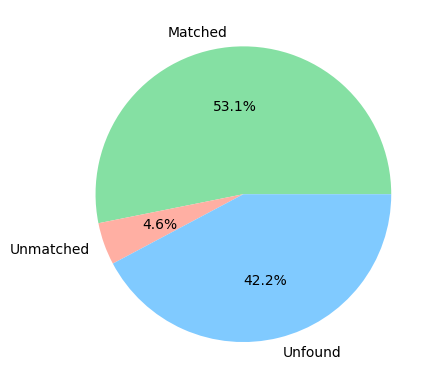

In [33]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

colors = ["#85E0A3", "#FFAFA3", "#80CAFF"]

# Calculate the total counts for each category
total_matched = df["match_count"].sum()
total_unmatched = df["unmatch_count"].sum()
total_unfound = df["unfound_count"].sum()

# Create a pie chart
plt.pie(
    [total_matched, total_unmatched, total_unfound],
    labels=["Matched", "Unmatched", "Unfound"],
    autopct="%1.1f%%",
    colors=colors,
)

# plt.title('Proportion of Matched, Unmatched, and Unfound Entities', pad=15, weight='bold')

# Save the plot to a PDF file
plt.savefig("proportion_matched_unmatched_unfound.pdf", format="pdf")

plt.show()

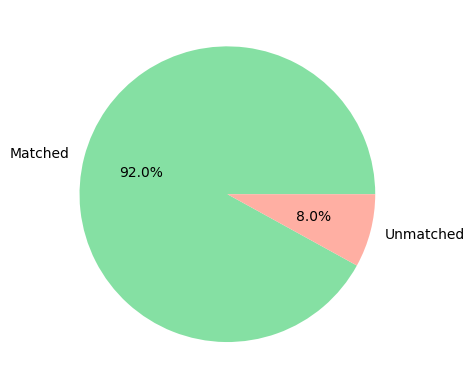

In [32]:
# Calculate the total counts for each category
total_matched = df["match_count"].sum()
total_unmatched = df["unmatch_count"].sum()

colors = ["#85E0A3", "#FFAFA3"]

# Create a pie chart
plt.pie(
    [total_matched, total_unmatched],
    labels=["Matched", "Unmatched"],
    autopct="%1.1f%%",
    colors=colors,
)

# Save the plot to a PDF file
plt.savefig("proportion_matched_unmatched.pdf", format="pdf")

plt.show()